# 10. CNN with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 10.1 Prepare MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

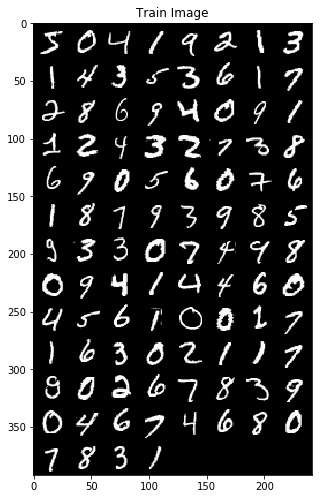

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape, labels[0:5]

(torch.Size([100, 1, 28, 28]), tensor([5, 0, 4, 1, 9]))

## 10.2 Define Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

In [9]:
model = CNN().cuda()

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## 10.3 Train Model

In [11]:
num_epochs = 5

In [12]:
save_path = './model/'
model_path = save_path + 'model.pkl'

In [13]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [14]:
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model Loaded!")

else:
    
    for epoch in range(num_epochs):

        total_batch = len(mnist_train) // batch_size

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            X = batch_images.cuda()
            Y = batch_labels.cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

    if not os.path.isfile(model_path):
        print("Model Saved!")
        torch.save(model.state_dict(), model_path)

Epoch [1/5], lter [100/600], Loss: 0.6324
Epoch [1/5], lter [200/600], Loss: 0.2464
Epoch [1/5], lter [300/600], Loss: 0.1897
Epoch [1/5], lter [400/600], Loss: 0.0988
Epoch [1/5], lter [500/600], Loss: 0.1224
Epoch [1/5], lter [600/600], Loss: 0.2676
Epoch [2/5], lter [100/600], Loss: 0.0219
Epoch [2/5], lter [200/600], Loss: 0.0210
Epoch [2/5], lter [300/600], Loss: 0.0650
Epoch [2/5], lter [400/600], Loss: 0.0396
Epoch [2/5], lter [500/600], Loss: 0.0931
Epoch [2/5], lter [600/600], Loss: 0.2203
Epoch [3/5], lter [100/600], Loss: 0.0150
Epoch [3/5], lter [200/600], Loss: 0.0110
Epoch [3/5], lter [300/600], Loss: 0.0247
Epoch [3/5], lter [400/600], Loss: 0.0189
Epoch [3/5], lter [500/600], Loss: 0.0677
Epoch [3/5], lter [600/600], Loss: 0.1903
Epoch [4/5], lter [100/600], Loss: 0.0127
Epoch [4/5], lter [200/600], Loss: 0.0071
Epoch [4/5], lter [300/600], Loss: 0.0157
Epoch [4/5], lter [400/600], Loss: 0.0116
Epoch [4/5], lter [500/600], Loss: 0.0502
Epoch [4/5], lter [600/600], Loss:

## 10.4 Test Model

In [15]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 98.930000 %
